In [1]:
import gzip
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.rc('font', family='serif', size=8)
plt.rc('text', usetex=True)

In [2]:
fname = 'res/finer_dim/all.jsonl.gz'
res = [json.loads(line) for line in gzip.open(fname)]
df = pd.DataFrame(res)
df.head()

,model,optimizer,lr,N,M,d,ntrain,batch_size,niter,layernorm,seed,error
0,matrix,Adam,0.1,100,5,10,102400,256,400,False,42,0.037157
1,learnable,Adam,0.1,100,5,10,10240,16,640,True,43,0.006427
2,exponential,SGD,100.0,100,5,10,10240,256,40,True,43,0.023662
3,matrix,Adam,100.0,100,5,10,10240,16,640,False,44,0.023956
4,learnable,Adam,10.0,100,5,10,1024,256,4,True,45,0.274714


In [3]:
# make a dataframe with tuned lr
keys = ['model', 'optimizer', 'N', 'M', 'd', 'ntrain', 'batch_size', 'layernorm', 'seed']
dftune = df.loc[df.groupby(keys).error.idxmin()].copy()
print(len(df), len(dftune))

40320 10080


## error vs dimension

Text(0.5, 1.0, '$|B|$=1024, lr=0.1, T=102400')

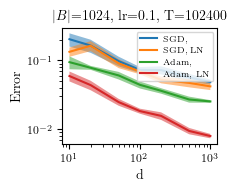

In [30]:
model = "matrix"
bs = 1024
lr = 0.1
# lr = None  # tuned lr
ntr = 1024*100

if lr is not None:  # fixed lr
    dff = df[(df.model == model) & (df.batch_size == bs) & (df.lr == lr) & (df.ntrain == ntr)]
else:  # tuned lr
    dff = dftune[(dftune.model == model) & (dftune.batch_size == bs) & (dftune.ntrain == ntr)]

opt_ln = [("SGD", False), ("SGD", True), ("Adam", False), ("Adam", True)]
# opt_ln = [("SGD", False), ("Adam", False)]

fig, ax = plt.subplots(figsize=(2, 1.5))
lns_str = {False: "", True: "LN"}

for opt, ln in opt_ln:
    groups = dff[(dff.optimizer == opt) & (dff.layernorm == ln)].groupby('d')
    errs = groups.error.mean()
    std = groups.error.std()
    ax.loglog(errs.index, errs, label=f"{opt}, {lns_str[ln]}")
    ax.fill_between(errs.index, errs - 0.5*std, errs + 0.5*std, alpha=.5)

ax.legend(fontsize=6, loc='upper right')
ax.set_xlabel('d', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.set_title(f'$|B|$={bs}, lr={lr}, T={ntr}', fontsize=10)

## error vs T

Text(0.5, 1.0, '$|B|$=1024, lr=0.1, d=100')

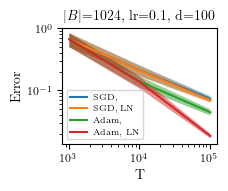

In [41]:
model = "matrix"
bs = 1024
lr = .1
# lr = None # tuned lr
d = 100

if lr is not None:  # fixed lr
    dff = df[(df.model == model) & (df.batch_size == bs) & (df.lr == lr) & (df.d == d)]
else:  # tuned lr
    dff = dftune[(dftune.model == model) & (dftune.batch_size == bs) & (dftune.d == d)]

opt_ln = [("SGD", False), ("SGD", True), ("Adam", False), ("Adam", True)]

fig, ax = plt.subplots(figsize=(2, 1.5))
lns_str = {False: "", True: "LN"}

for opt, ln in opt_ln:
    groups = dff[(dff.optimizer == opt) & (dff.layernorm == ln)].groupby('ntrain')
    errs = groups.error.mean()
    std = groups.error.std()
    ax.loglog(errs.index, errs, label=f"{opt}, {lns_str[ln]}")
    ax.fill_between(errs.index, errs - 0.5*std, errs + 0.5*std, alpha=.5)

ax.legend(fontsize=6, loc='lower left')
ax.set_xlabel('T', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.set_title(f'$|B|$={bs}, lr={lr}, d={d}', fontsize=10)

## Batch size

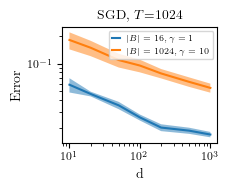

In [6]:
model = "matrix"
bs = 16
# lr = None  # tuned lr
ntr = 1024

fig, ax = plt.subplots(figsize=(2, 1.5))
leg = []

# if lr is not None:  # fixed lr
for bs in [16, 1024]:
    if bs == 16:
        lr = 1
    else:
        lr = 10.
    groups = df[(df.model == model) & (df.batch_size == bs) & (df.lr == lr) & (df.ntrain == ntr) & 
             (df.optimizer == "Adam") & (df.layernorm == False)].groupby('d')

    errs = groups.error.mean()
    std = groups.error.std()
    a, = ax.loglog(errs.index, errs, label=f"$|B| = {bs}$")
    ax.fill_between(errs.index, errs - 0.5*std, errs + 0.5*std, alpha=.5)
    leg.append(a)

ax.legend(leg, [r'$\vert B\vert=16, \gamma=1$', r'$\vert B\vert=1024, \gamma=10$'], fontsize=6, loc='upper right', handlelength=1)
ax.set_xlabel('d', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.set_title(f'SGD, $T$={ntr}')
fig.savefig('figures/bs.pdf', bbox_inches='tight')

## LR

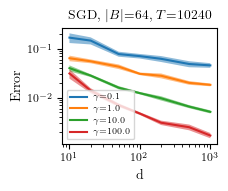

In [7]:
model = "matrix"
bs = 64
# lr = 1.
opti = "SGD"
ln = False
ntr = 1024*10

fig, ax = plt.subplots(figsize=(2, 1.5))

# if lr is not None:  # fixed lr
for lr in [0.1, 1.0, 10., 100.]:
    groups = df[(df.model == model) & (df.batch_size == bs) & (df.lr == lr) & (df.ntrain == ntr) & 
             (df.optimizer == opti) & (df.layernorm == ln)].groupby('d')

    errs = groups.error.mean()
    std = groups.error.std()
    ax.loglog(errs.index, errs, label=f"$\gamma$={lr}")
    ax.fill_between(errs.index, errs - 0.5*std, errs + 0.5*std, alpha=.5)

ax.legend(fontsize=6, loc='lower left')
ax.set_xlabel('d', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.set_title(f'{opti}, $|B|$={bs}, $T$={ntr}')
fig.savefig('figures/lr.pdf', bbox_inches='tight')

## Adam vs SGD

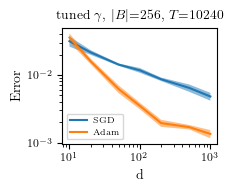

In [8]:
model = "matrix"
bs = 256
# lr = 10.
# lr = None  # tuned lr
ntr = 1024*10

fig, ax = plt.subplots(figsize=(2, 1.5))
# if lr is not None:  # fixed lr
for opti in ["SGD", "Adam"]:
    groups = dftune[(dftune.model == model) & (dftune.batch_size == bs) & (dftune.ntrain == ntr) & 
                    (dftune.optimizer == opti) & (dftune.layernorm == False)].groupby('d')

    errs = groups.error.mean()
    std = groups.error.std()
    ax.loglog(errs.index, errs, label=opti)
    ax.fill_between(errs.index, errs - 0.5*std, errs + 0.5*std, alpha=.5)

ax.legend(fontsize=6, loc='lower left')
ax.set_xlabel('d', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.set_title(f'tuned $\gamma$, $|B|$={bs}, $T$={ntr}')
fig.savefig('figures/adam.pdf', bbox_inches='tight')

## Layernorm

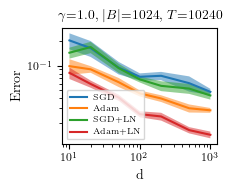

In [9]:
model = "matrix"
bs = 1024
lr = 1.
# lr = None  # tuned lr
ntr = 1024*10

fig, ax = plt.subplots(figsize=(2, 1.5))
# if lr is not None:  # fixed lr
for ln in [False, True]:
    for opti in ["SGD", "Adam"]:
        groups = df[(df.model == model) & (df.batch_size == bs) & (df.lr == lr) & (df.ntrain == ntr) & 
                 (df.optimizer == opti) & (df.layernorm == ln)].groupby('d')

        errs = groups.error.mean()
        std = groups.error.std()
        ax.loglog(errs.index, errs, label=opti + ("+LN" if ln else ""))
        ax.fill_between(errs.index, errs - 0.5*std, errs + 0.5*std, alpha=.5)

ax.legend(fontsize=6, loc='lower left')
ax.set_xlabel('d', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.set_title(f'$\gamma$={lr}, $|B|$={bs}, $T$={ntr}')
fig.savefig('figures/ln.pdf', bbox_inches='tight')

# Learning the embeddings

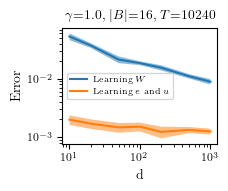

In [10]:
bs = 16
lr = 1.
ntr = 1024*10
ln = False
opti = "SGD"

fig, ax = plt.subplots(figsize=(2, 1.5))
leg = []
for model in ["matrix", "learnable"]:
    groups = df[(df.model == model) & (df.batch_size == bs) & (df.lr == lr) & (df.ntrain == ntr) & 
            (df.optimizer == opti) & (df.layernorm == ln)].groupby('d')

    errs = groups.error.mean()
    std = groups.error.std()
    a, = ax.loglog(errs.index, errs)
    ax.fill_between(errs.index, errs - 0.5*std, errs + 0.5*std, alpha=.5)

    leg.append(a)

ax.legend(leg, ['Learning $W$', 'Learning $e$ and $u$'], fontsize=6, loc='best')
ax.set_xlabel('d', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.set_title(f'$\gamma$={lr}, $|B|$={bs}, $T$={ntr}')
fig.savefig('figures/embeddings.pdf', bbox_inches='tight')